<a href="https://colab.research.google.com/github/ArthurCbn/TIPE/blob/main/TIPE_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CheXpert Classification

### Dependencies

In [3]:
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### Importing dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
!7za x /content/drive/MyDrive/data/train.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/data/                                      1 file, 11500025501 bytes (11 GiB)

Extracting archive: /content/drive/MyDrive/data/train.zip
  0% 256 Open               2% 1792 Open                3% 2048 Open                3% 2560 Open                4% 2816 Open                4% 3072 Open                5% 3584 Open                5% 3840 Open                6% 4096 Open                7% 4608 Open

## Data Fetching

In [ ]:
dataset_dir = "/content/drive/MyDrive/data"
img_size = (224, 224, 1)
max_size = 5000

# Récupère les fichiers csv
csv_train = pd.read_csv("{}/train.csv".format(dataset_dir), index_col=0)
csv_test = pd.read_csv("{}/valid.csv".format(dataset_dir), index_col=0)

# Garde seulement les fichiers présent dans le dataset
csv_train["Patient"] = [p.split("/")[2] for p in csv_train.index]
patients_train = os.listdir("{}/{}".format(dataset_dir, "/train"))
patients_train = [p for p in patients_train if os.listdir("{}/train/{}".format(dataset_dir, p)) != []]
csv_train = csv_train.where(csv_train.Patient.isin(patients_train)).dropna(how="all")

size_train, size_valid = len(csv_train), len(csv_test)

# Classes
classes = ["Enlarged Cardiomediastinum", 
           "Cardiomegaly", 
           "Lung Opacity", 
           "Lung Lesion",
           "Edema",
           "Consolidation", 
           "Pneumonia", 
           "Atelectasis", 
           "Pneumothorax", 
           "Pleural Effusion", 
           "Pleural Other",
           "Fracture"]

images_train = []
targets_train = []
images_test = []
targets_test = []
    
### Créer les arrays d'images et de targets associées ###
to_do = max_size + size_valid - 1
i = 0

# Train
for path in csv_train.index:
    
    # On ne traite que les images frontales
    if csv_train.loc[path]["Frontal/Lateral"] == "Frontal":
  
        img_path = "{}/{}".format(dataset_dir, path.split("CheXpert-v1.0-small/")[1])
         
        # Redimensionne les images
        img = Image.open(img_path)
        img = img.resize((img_size[0], img_size[1]), Image.ANTIALIAS)
        img = np.asarray(img, dtype="float32") # float32 pour conv
        
        images_train.append(img)

        target = np.array([1 if csv_train.loc[path][c] == 1.0 else 0 for c in classes])
        targets_train.append(target)
                
        # Barre de chargement
        done = i/to_do
        print("Fetching : {}% |{}| {}/{}".format(int(done*1000)/10, "#"*int(done*20) + "-"*(20-int(done*20)), i, to_do), end="\r")
        i+=1
    
    if i >=max_size:
        break

# Test
for path in csv_test.index:
    
    # On ne traite que les images frontales
    if csv_test.loc[path]["Frontal/Lateral"] == "Frontal":
    
        img_path = "{}/{}".format(dataset_dir, path.split("CheXpert-v1.0-small/")[1])

        # Redimensionne les images
        img = Image.open(img_path)
        img = img.resize((img_size[0], img_size[1]), Image.ANTIALIAS)
        img = np.asarray(img, dtype="float32") # float32 pour conv
        
        images_test.append(img)

        target = np.array([1 if csv_test.loc[path][c] == 1.0 else 0 for c in classes])
        targets_test.append(target)
            
        # Barre de chargement
        done = i/to_do
        print("Fetching : {}% |{}| {}/{}".format(int(done*1000)/10, "#"*int(done*20) + "-"*(20-int(done*20)), i, to_do), end="\r")
        i+=1

print()

### Pré-processing des données ###
print("Preprocessing...", end="\r")

images_train = np.array(images_train)
targets_train = np.array(targets_train)
images_test = np.array(images_test)
targets_test = np.array(targets_test)


# Normalisation des données
scaler = StandardScaler()
scaled_images_train = scaler.fit_transform(images_train.reshape(-1, img_size[0]*img_size[1]*img_size[2]))
scaled_images_test = scaler.transform(images_test.reshape(-1, img_size[0]*img_size[1]*img_size[2]))

scaled_images_train = scaled_images_train.reshape(-1, img_size[0], img_size[1], img_size[2])
scaled_images_test = scaled_images_test.reshape(-1, img_size[0], img_size[1], img_size[2])

print("# Data Ready ! #")

## Model

#### AlexNet

In [ ]:
model_AlexNet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='sigmoid')
], name="AlexNet")

#### VGG16

In [ ]:
model_VGG16 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same", input_shape=(224, 224, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='sigmoid')
], name="VGG16")

#### DenseNet

In [ ]:
model_DenseNet = None

### Setting up the model

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

### Compile models

In [ ]:
# AlexNet
model_AlexNet.compile(
    loss=loss_object,
    optimizer=optimizer,
    metrics=["accuracy"])

model_AlexNet.summary()

# VGG16
model_VGG16.compile(
    loss=loss_object,
    optimizer=optimizer,
    metrics=["accuracy"])

model_VGG16.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       8851

## Training

In [ ]:
epochs = 1
batch_size = 32
model = model_VGG16

history = model.fit(scaled_images_train, targets_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

  2/100 [..............................] - ETA: 25:51 - loss: 1.0773 - accuracy: 0.0625

KeyboardInterrupt: 

### Visualization

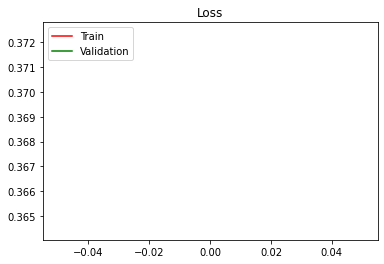

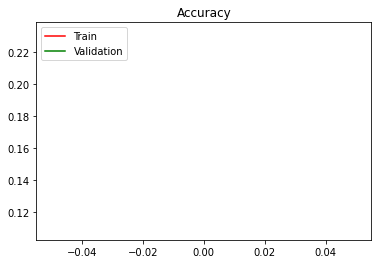

In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, "r", label="Train")
plt.plot(loss_val_curve, "g", label="Validation")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, "r", label="Train")
plt.plot(acc_val_curve, "g", label="Validation")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()